# Module 3 - Exercise 1: Data Pipeline & Training Loop

## Learning Objectives
- Generate complex synthetic regression data with multiple features
- Properly split data into train, validation, and test sets
- Create efficient data loaders with different batch sizes
- Implement a complete training loop with validation monitoring
- Compare training dynamics with different batch sizes
- Implement model checkpointing to save the best model
- Load and evaluate the best model vs final model

In [1]:
# Environment setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
# Use explicit device instead of torch.set_default_device to avoid device/CPU generator issues
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


## Section 1: Generate Complex Regression Data

We'll create a challenging regression problem that combines multiple non-linear patterns:
- Polynomial features
- Trigonometric components
- Interaction terms
- Controlled noise

The target function is:
$$y = 2\sin(2\pi x_1) + 3\cos(\pi x_2) + x_1^2 - 2x_2^2 + x_1 \cdot x_2 + x_3^3 - x_4 + \epsilon$$

where $x_i \in [-2, 2]$ and $\epsilon \sim \mathcal{N}(0, 0.2)$

Dataset shape: X=(5000, 4), y=(5000,)
Target statistics: mean=-1.31, std=4.88, min=-15.58, max=15.26


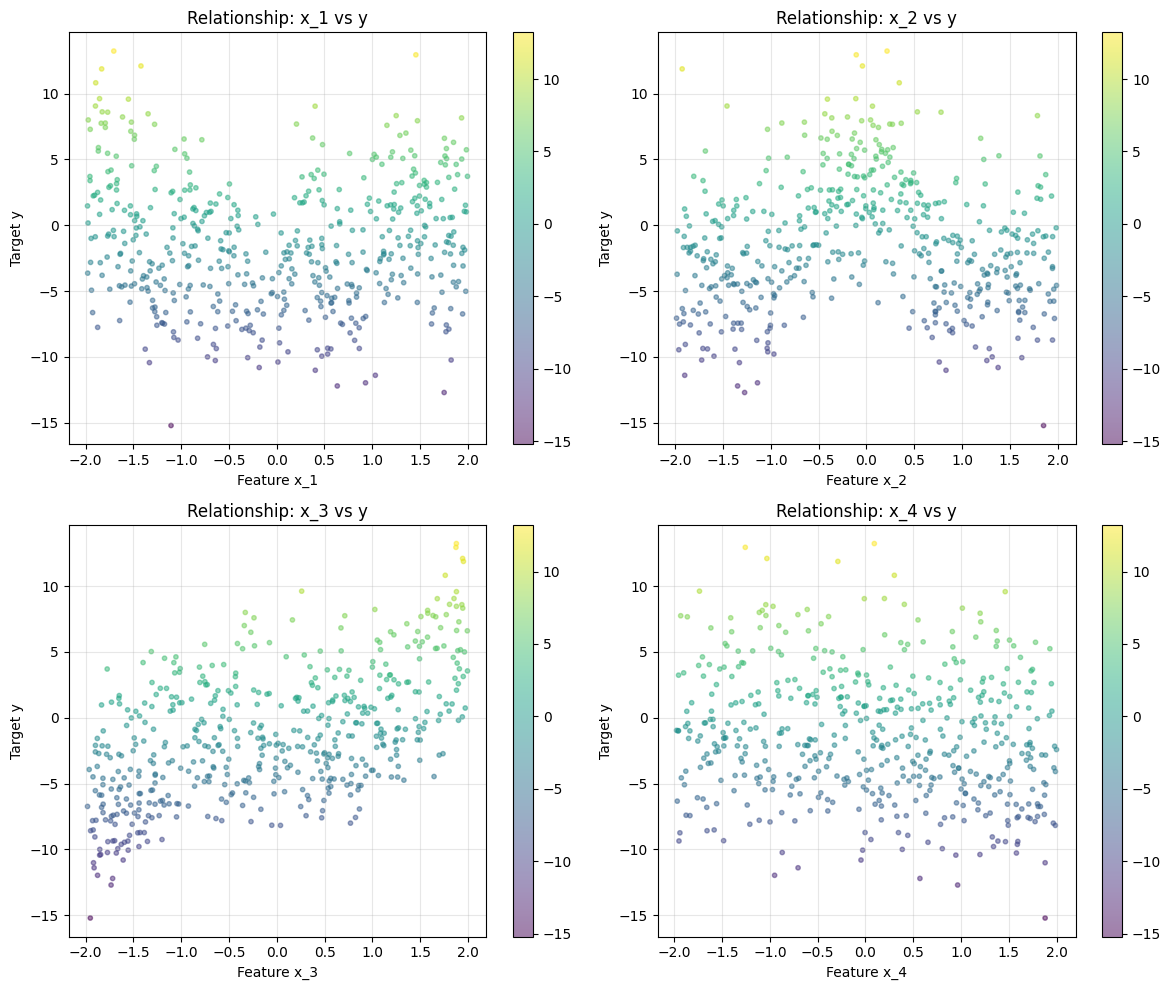

In [2]:
def generate_complex_regression_data(n_samples=5000, n_features=4, noise_std=0.2):
    """
    Generate synthetic regression data with complex non-linear relationships.
    """
    # Generate random input features
    X = np.random.uniform(-2, 2, size=(n_samples, n_features))
    
    # Complex target function
    y = (
        2 * np.sin(2 * np.pi * X[:, 0]) +      # Sinusoidal component
        3 * np.cos(np.pi * X[:, 1]) +          # Cosine component
        X[:, 0]**2 -                            # Quadratic term
        2 * X[:, 1]**2 +                        # Negative quadratic
        X[:, 0] * X[:, 1] +                     # Interaction term
        X[:, 2]**3 -                            # Cubic term
        X[:, 3]                                 # Linear term
    )
    
    # Add Gaussian noise
    y += np.random.normal(0, noise_std, size=n_samples)
    
    return X.astype(np.float32), y.astype(np.float32)

# Generate the dataset
X, y = generate_complex_regression_data(n_samples=5000)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Target statistics: mean={y.mean():.2f}, std={y.std():.2f}, min={y.min():.2f}, max={y.max():.2f}")

# Visualize the relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    scatter = ax.scatter(X[:500, i], y[:500], c=y[:500], cmap='viridis', alpha=0.5, s=10)
    ax.set_xlabel(f'Feature x_{i+1}')
    ax.set_ylabel('Target y')
    ax.set_title(f'Relationship: x_{i+1} vs y')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax)
plt.tight_layout()
plt.show()

## Section 2: Create Train, Validation, and Test Datasets

Split the data into three sets:
- Training set (60%): Used to train the model
- Validation set (20%): Used to tune hyperparameters and select the best model
- Test set (20%): Used for final evaluation

In [3]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# Split data into train+val (80%) and test (20%)
# Use train_test_split with test_size=0.2 and random_state=42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split train+val into train (75% of train+val) and validation (25% of train+val)
# This gives us 60% train, 20% val, 20% test of the original data
# Use train_test_split with test_size=0.25 and random_state=42
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# Print dataset sizes
if X_train is not None:
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples")

Training set: 3000 samples
Validation set: 1000 samples
Test set: 1000 samples
Total: 5000 samples


In [4]:
# Create torch dataset
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

## Section 3: Create DataLoaders

Create PyTorch DataLoaders for efficient batch processing during training. We'll experiment with different batch sizes later.

In [8]:
# Define batch size and create DataLoaders (leave tensors on CPU inside dataset)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

if train_loader:
    print(f"Train DataLoader: {len(train_loader)} batches")
    print(f"Validation DataLoader: {len(val_loader)} batches")
    print(f"Test DataLoader: {len(test_loader)} batches")
    
    # Check first batch (move to device to inspect shapes if needed)
    for batch_X, batch_y in train_loader:
        print(f"\nFirst batch shapes: X={batch_X.shape}, y={batch_y.shape}")
        break

Train DataLoader: 47 batches
Validation DataLoader: 16 batches
Test DataLoader: 16 batches

First batch shapes: X=torch.Size([64, 4]), y=torch.Size([64])


## Section 4: Define Model, Optimizer, and Loss Function

Create a neural network for regression with multiple hidden layers to capture the complex relationships in our data.

In [9]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dims=[64, 32, 16]):
        super(RegressionModel, self).__init__()
        
        # TODO: Build a neural network with the following architecture:
        # - Output layer: ->  output (regression)
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc1_activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc2_activation = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc3_activation = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dims[2], 1)  # Output layer

        self.dropout = None
        
    def forward(self, x):
        # TODO: Implement forward pass
        # forward pass : 
        x = self.fc1(x)
        x = self.fc1_activation(x)
        x = self.fc2(x)
        x = self.fc2_activation(x)
        x = self.fc3(x)
        x = self.fc3_activation(x)
        x = self.fc4(x) 

        return x 

# Create model instance
model = RegressionModel(input_dim=4)

# TODO: Choose an appropriate loss function for regression
# Hint: Mean Squared Error (MSE) is commonly used
criterion = nn.MSELoss()

# TODO: Choose an optimizer
# Use Adam optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), 0.001)

if model and criterion and optimizer:
    print("Model Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"\nLoss function: {criterion}")
    print(f"Optimizer: {optimizer.__class__.__name__}")

Model Architecture:
RegressionModel(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc1_activation): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc2_activation): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc3_activation): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

Total parameters: 2945

Loss function: MSELoss()
Optimizer: Adam


## Section 5: Training with Different Batch Sizes

Train the model with different batch sizes and compare the training dynamics. Smaller batch sizes typically lead to noisier gradients but can help escape local minima, while larger batch sizes provide more stable gradients.

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    """
    Train the model and track training/validation losses.
    
    Returns:
        train_losses: List of average training losses per epoch
        val_losses: List of average validation losses per epoch
    """
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        # TODO Loop on the right loader: for batch_X, batch_y in train_loader:
        for batch_X, batch_y in train_loader:   
            # TODO: Implement training step on the batch batch_X, batch_y
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            if loss is not None:
                train_loss += loss.item() * batch_X.size(0)
        
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader.dataset) if train_loader else 0
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                
                # TODO: Compute validation loss
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))
                
                if loss is not None:
                    val_loss += loss.item() * batch_X.size(0)
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset) if val_loader else 0
        val_losses.append(avg_val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses


In [34]:

# TODO: Train models with different batch sizes
batch_sizes = [16, 32, 64, 128]
results = {}

for bs in batch_sizes:
    print(f"\n{'='*50}")
    print(f"Training with batch size: {bs}")
    print(f"{'='*50}")
    
    train_loader_bs = DataLoader(train_dataset, batch_size=bs, shuffle=True, generator=torch.Generator('cuda'))
    val_loader_bs = DataLoader(val_dataset, batch_size=bs, shuffle=False, generator=torch.Generator('cuda'))

    # Create fresh model and optimizer for fair comparison
    model_bs = RegressionModel(input_dim=4, hidden_dims=[64, 32, 16])
    optimizer_bs = optim.Adam(model_bs.parameters(), lr=0.001) if model_bs else None
    
    # Train the model
    if model_bs and criterion and optimizer_bs and train_loader_bs:
        train_losses, val_losses = train_model(
            model_bs, train_loader, val_loader, 
            criterion, optimizer_bs, num_epochs=50
        )
        results[bs] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'model': model_bs
        }


Training with batch size: 16
Epoch [10/50], Train Loss: 4.8732, Val Loss: 5.3200
Epoch [20/50], Train Loss: 3.1060, Val Loss: 3.4222
Epoch [30/50], Train Loss: 2.4825, Val Loss: 2.7901
Epoch [40/50], Train Loss: 2.1597, Val Loss: 2.3649
Epoch [50/50], Train Loss: 2.0685, Val Loss: 2.2829

Training with batch size: 32
Epoch [10/50], Train Loss: 5.5443, Val Loss: 6.0445
Epoch [20/50], Train Loss: 3.4765, Val Loss: 3.8617
Epoch [30/50], Train Loss: 2.3643, Val Loss: 2.5708
Epoch [40/50], Train Loss: 2.1403, Val Loss: 2.2884
Epoch [50/50], Train Loss: 2.0729, Val Loss: 2.2253

Training with batch size: 64
Epoch [10/50], Train Loss: 4.9407, Val Loss: 5.2058
Epoch [20/50], Train Loss: 3.2199, Val Loss: 3.5565
Epoch [30/50], Train Loss: 2.3382, Val Loss: 2.6287
Epoch [40/50], Train Loss: 2.0762, Val Loss: 2.2220
Epoch [50/50], Train Loss: 2.0275, Val Loss: 2.1722

Training with batch size: 128
Epoch [10/50], Train Loss: 4.9238, Val Loss: 5.3935
Epoch [20/50], Train Loss: 2.9210, Val Loss: 3.

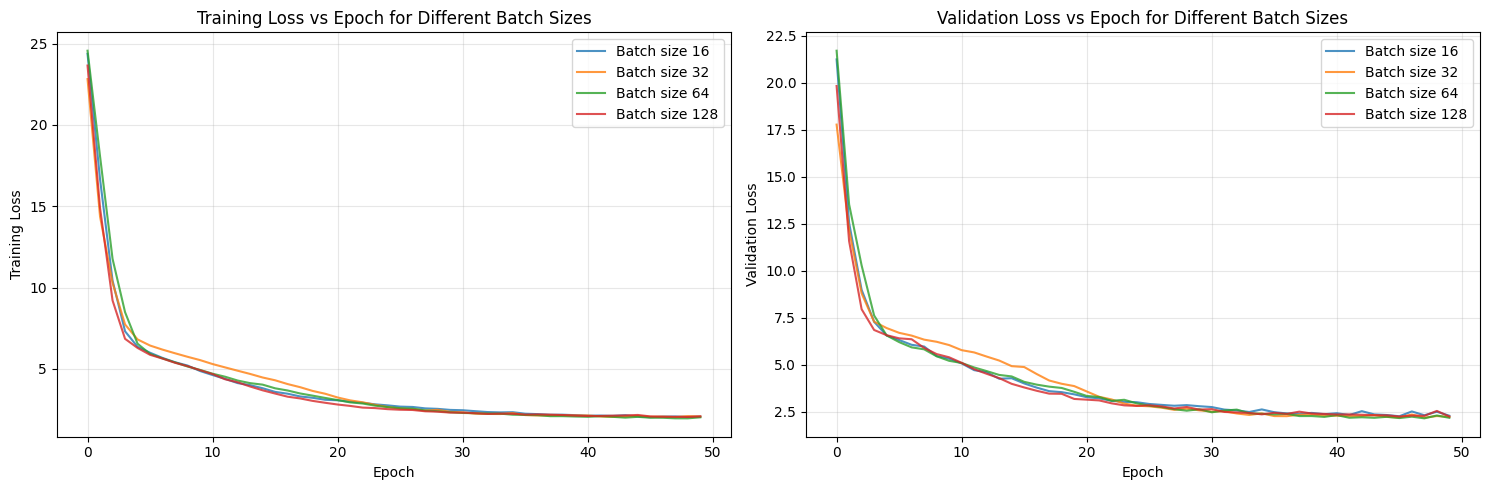


Final Losses Comparison:
Batch Size      Final Train Loss     Final Val Loss      
-------------------------------------------------------
16              2.0685               2.2829              
32              2.0729               2.2253              
64              2.0275               2.1722              
128             2.0853               2.2412              


In [35]:
# TODO: Plot training and validation losses for different batch sizes
if results:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training losses
    ax1 = axes[0]
    for bs, data in results.items():
        ax1.plot(data['train_losses'], label=f'Batch size {bs}', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss vs Epoch for Different Batch Sizes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot validation losses
    ax2 = axes[1]
    for bs, data in results.items():
        ax2.plot(data['val_losses'], label=f'Batch size {bs}', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss vs Epoch for Different Batch Sizes')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final losses for comparison
    print("\nFinal Losses Comparison:")
    print(f"{'Batch Size':<15} {'Final Train Loss':<20} {'Final Val Loss':<20}")
    print("-" * 55)
    for bs, data in results.items():
        final_train = data['train_losses'][-1]
        final_val = data['val_losses'][-1]
        print(f"{bs:<15} {final_train:<20.4f} {final_val:<20.4f}")

## Section 6: Model Checkpointing

Implement model checkpointing to save the best model based on validation loss. This ensures we keep the model that generalizes best, not just the final model which might be overfitting.

In [39]:
def train_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, 
                         num_epochs=100, checkpoint_path='best_model.pth'):
    """
    Train the model with checkpointing to save the best model based on validation loss.
    
    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
        best_epoch: Epoch with best validation loss
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X, batch_y
            
            # TODO: Implement training step (same as before)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            
            if loss is not None:
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X, batch_y

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))

                if loss is not None:
                    val_loss += loss.item() * batch_X.size(0)
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # TODO: Check if this is the best model so far
        # If validation loss is better than best_val_loss:
        # 1. Update best_val_loss and best_epoch
        # 2. Save the model state dict using torch.save()
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss  # TODO: Update this
            best_epoch = epoch  # TODO: Update this
            # TODO: Save model checkpoint
            torch.save(model.state_dict(), checkpoint_path)
            
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch+1})')
    
    return train_losses, val_losses, best_epoch


In [52]:
# Train a new model with checkpointing
print("Training model with checkpointing...")
print("="*50)

# Create fresh model and optimizer
final_model = RegressionModel(input_dim=4, hidden_dims=[64, 32, 16])
final_optimizer = optim.Adam(final_model.parameters(), lr=0.001) if final_model else None

# Use batch size 32 for final training
if X_train is not None and final_model and criterion and final_optimizer:
    train_loader_final = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader_final = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader_final = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Train with checkpointing
    train_losses_final, val_losses_final, best_epoch = train_with_checkpoint(
        final_model, train_loader_final, val_loader_final,
        criterion, final_optimizer, num_epochs=1000, checkpoint_path='best_model.pth'
    )
    
    print(f"\nTraining completed. Best model was at epoch {best_epoch+1}")

Training model with checkpointing...
Epoch [20/1000], Train Loss: 2.2165, Val Loss: 2.3028, Best Val Loss: 2.3028 (Epoch 20)
Epoch [40/1000], Train Loss: 1.9335, Val Loss: 2.0613, Best Val Loss: 2.0400 (Epoch 36)
Epoch [60/1000], Train Loss: 1.7092, Val Loss: 1.7816, Best Val Loss: 1.7698 (Epoch 57)
Epoch [80/1000], Train Loss: 1.5411, Val Loss: 1.6615, Best Val Loss: 1.6615 (Epoch 80)
Epoch [100/1000], Train Loss: 1.3746, Val Loss: 1.4780, Best Val Loss: 1.4780 (Epoch 100)
Epoch [120/1000], Train Loss: 0.9855, Val Loss: 1.1811, Best Val Loss: 1.0413 (Epoch 118)
Epoch [140/1000], Train Loss: 0.6679, Val Loss: 0.7754, Best Val Loss: 0.7214 (Epoch 139)
Epoch [160/1000], Train Loss: 0.5460, Val Loss: 0.5693, Best Val Loss: 0.5693 (Epoch 160)
Epoch [180/1000], Train Loss: 0.3741, Val Loss: 0.4826, Best Val Loss: 0.4664 (Epoch 174)
Epoch [200/1000], Train Loss: 0.4102, Val Loss: 0.3528, Best Val Loss: 0.3528 (Epoch 200)
Epoch [220/1000], Train Loss: 0.2970, Val Loss: 0.3668, Best Val Loss: 

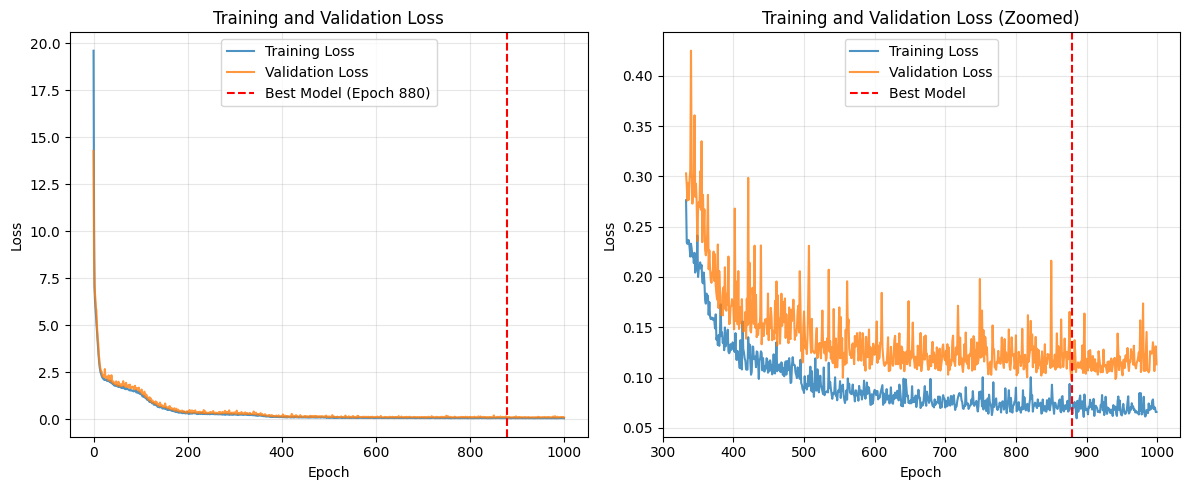

In [53]:
# Plot training history with best epoch marked
if 'train_losses_final' in locals() and 'val_losses_final' in locals():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_final, label='Training Loss', alpha=0.8)
    plt.plot(val_losses_final, label='Validation Loss', alpha=0.8)
    if 'best_epoch' in locals():
        plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Zoom in on later epochs to see overfitting more clearly
    start_epoch = max(0, len(train_losses_final) // 3)
    plt.plot(range(start_epoch, len(train_losses_final)), 
             train_losses_final[start_epoch:], label='Training Loss', alpha=0.8)
    plt.plot(range(start_epoch, len(val_losses_final)), 
             val_losses_final[start_epoch:], label='Validation Loss', alpha=0.8)
    if 'best_epoch' in locals() and best_epoch >= start_epoch:
        plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Zoomed)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Section 7: Load Best Model and Compare Performance

Load the best model from checkpoint and compare its performance with the final model on the test set. This demonstrates the importance of model selection based on validation performance.

In [54]:
def evaluate_model(model, test_loader, criterion):
    """
    Evaluate model on test set.
    
    Returns:
        test_loss: Average test loss
        predictions: Model predictions
        targets: True target values
    """
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X, batch_y
            
            # TODO: Get model predictions
            outputs = model(batch_X)
            
            if outputs is not None:
                # Calculate loss
                loss = criterion(outputs, batch_y)
                test_loss += loss.item() * batch_X.size(0)
                
                # Store predictions and targets
                predictions.extend(outputs.cpu().numpy())
                targets.extend(batch_y.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader.dataset) if test_loader else 0
    
    return avg_test_loss, np.array(predictions), np.array(targets)

# TODO: Load the best model from checkpoint
best_model = RegressionModel(input_dim=4, hidden_dims=[64, 32, 16])

# TODO: Load the saved state dict
# Check if checkpoint file exists first
if os.path.exists('best_model.pth'):
    # TODO: Load state dict using torch.load()
    best_model.load_state_dict(torch.load('best_model.pth'))
    
    
# Evaluate both models on test set
if 'final_model' in locals() and 'best_model' in locals() and 'test_loader_final' in locals():
    # Evaluate final model (last epoch)
    final_test_loss, final_preds, final_targets = evaluate_model(
        final_model, test_loader_final, criterion
    )
    
    # Evaluate best model (from checkpoint)
    best_test_loss, best_preds, best_targets = evaluate_model(
        best_model, test_loader_final, criterion
    )
    
    # TODO: Calculate additional metrics (RMSE, MAE)
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    if len(final_preds) > 0 and len(best_preds) > 0:
        # Final model metrics
        final_rmse = np.sqrt(mean_squared_error(final_targets, final_preds))
        final_mae = mean_absolute_error(final_targets, final_preds)
        final_r2 = r2_score(final_targets, final_preds)
        
        # Best model metrics
        best_rmse = np.sqrt(mean_squared_error(best_targets, best_preds))
        best_mae = mean_absolute_error(best_targets, best_preds)
        best_r2 = r2_score(best_targets, best_preds)
        
        # Print comparison
        print("\n" + "="*60)
        print("Model Performance Comparison on Test Set")
        print("="*60)
        print(f"{'Metric':<20} {'Final Model':<20} {'Best Model':<20}")
        print("-"*60)
        print(f"{'Test Loss (MSE)':<20} {final_test_loss:<20.4f} {best_test_loss:<20.4f}")
        print(f"{'RMSE':<20} {final_rmse:<20.4f} {best_rmse:<20.4f}")
        print(f"{'MAE':<20} {final_mae:<20.4f} {best_mae:<20.4f}")
        print(f"{'R² Score':<20} {final_r2:<20.4f} {best_r2:<20.4f}")
        print("="*60)
        
        # Calculate improvement
        improvement = ((final_test_loss - best_test_loss) / final_test_loss) * 100
        print(f"\nBest model improvement over final model: {improvement:.2f}%")
        if 'best_epoch' in locals():
            print(f"Best model was saved at epoch {best_epoch+1} out of 100 epochs")


Model Performance Comparison on Test Set
Metric               Final Model          Best Model          
------------------------------------------------------------
Test Loss (MSE)      48.3087              48.2653             
RMSE                 0.3210               0.2973              
MAE                  0.2562               0.2379              
R² Score             0.9958               0.9964              

Best model improvement over final model: 0.09%
Best model was saved at epoch 880 out of 100 epochs


C:\Users\cheri\AppData\Local\Temp\ipykernel_9260\2016863807.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))
d:\

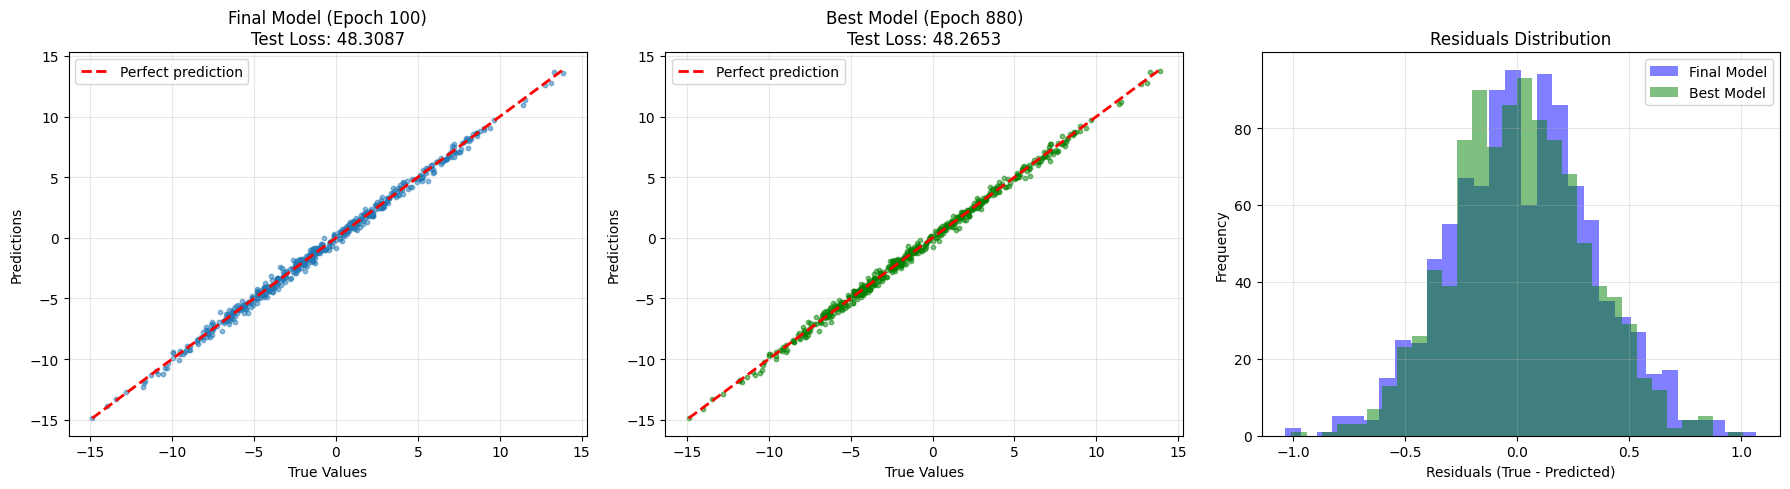


Residuals Statistics:
Final Model - Mean: 0.0277, Std: 0.3198
Best Model - Mean: 0.0132, Std: 0.2970


In [57]:
# Visualize predictions comparison
if 'final_preds' in locals() and 'best_preds' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Final model predictions vs actual
    ax1 = axes[0]
    ax1.scatter(final_targets[:500], final_preds[:500], alpha=0.5, s=10)
    ax1.plot([final_targets.min(), final_targets.max()], 
             [final_targets.min(), final_targets.max()], 
             'r--', lw=2, label='Perfect prediction')
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predictions')
    ax1.set_title(f'Final Model (Epoch 100)\nTest Loss: {final_test_loss:.4f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Best model predictions vs actual
    ax2 = axes[1]
    ax2.scatter(best_targets[:500], best_preds[:500], alpha=0.5, s=10, color='green')
    ax2.plot([best_targets.min(), best_targets.max()], 
             [best_targets.min(), best_targets.max()], 
             'r--', lw=2, label='Perfect prediction')
    ax2.set_xlabel('True Values')
    ax2.set_ylabel('Predictions')
    if 'best_epoch' in locals():
        ax2.set_title(f'Best Model (Epoch {best_epoch+1})\nTest Loss: {best_test_loss:.4f}')
    else:
        ax2.set_title(f'Best Model\nTest Loss: {best_test_loss:.4f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Residuals comparison
    ax3 = axes[2]
    final_residuals = final_targets - final_preds.flatten()
    best_residuals = best_targets - best_preds.flatten()
    
    ax3.hist(final_residuals, bins=30, alpha=0.5, label='Final Model', color='blue')
    ax3.hist(best_residuals, bins=30, alpha=0.5, label='Best Model', color='green')
    ax3.set_xlabel('Residuals (True - Predicted)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Residuals Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nResiduals Statistics:")
    print(f"Final Model - Mean: {final_residuals.mean():.4f}, Std: {final_residuals.std():.4f}")
    print(f"Best Model - Mean: {best_residuals.mean():.4f}, Std: {best_residuals.std():.4f}")